
<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center"> Cats vs Dogs </h2>
    <h2 align="center" style="color:#01ff84"> Loading your dataset</h2>
<div>

<br>
    
So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src="imgs/dog.png" width="200" height="40" />
<img src="imgs/cat.png" width="200" height="40" />
    

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.
    
<br>
    
Start importing the needed libraries:
    


In [111]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms


The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). They are already splitted into a training set and test set.

 
>**Exercise:** Download the dataset and place the train and test set in the `datasets/cat_vs_dog` folder. If you're cloning this from github, you should have it in `../datasets/`. So first create the `cat_vs_dog` folder in `datasets` and verify that the data are there by running `ls ../datasets/cat_vs_dog` (or your custom path if you changed it).

Great! Now that you have downloaded your data, you need to define the transformations to be passed to the `ImageFolder` function. You have already used them with the MNIST dataset (see the Data Augmentation workbook in Pytorch). While for MNIST you were passing the transformation in the following line of code

`datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)`

here you do it in the `ImageFolder` method. You can think it as a way to work on every dataset, not only on the MNIST one.


### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. 

As in the other notebook, you can use the following transformations:

```python
transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

```

**WARNING!** Remember that transformation are super useful for "augmenting" your training data, so that you make your network less vulnerable to different sizes, rotations, or cropping. However, when you are on the test data, there is no need of augmenting the data! Actually, it is not a good practice to do that because there would be very repetitive test data that invalidates your score.

For this reason, define two different transformations for training and test data (remember that `ToTensor()` and normalization are necessary also for the test data, as well as the resizing (you can use `transforms.Resize(size)` for it):



In [112]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])



test_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])


data_dir = "../input/cat-and-dog" # or the path where you have downloaded the dataset

train_data = datasets.ImageFolder(data_dir + '/training_set/training_set', transform=train_transform)
test_data = datasets.ImageFolder(data_dir + '/test_set/test_set', transform=test_transform)

Now that you have you have defined the needed transformation, it's time to build the Data loader itself!

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Build the dataloader for both the train and test data. Choose the batch size that fits your memory. 
**Remember** NOT TO shuffle the test data! 

In [113]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

<AxesSubplot:>

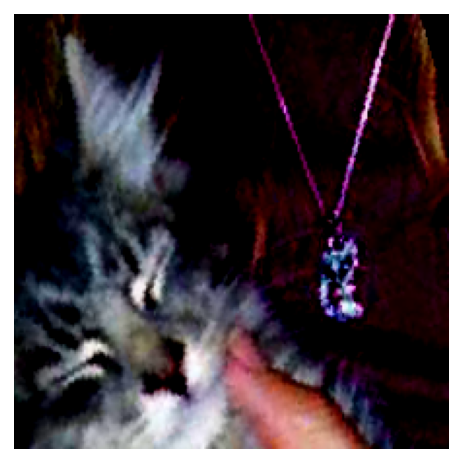

In [114]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# Run this to test your data loaders
images, labels = next(iter(trainloader))
imshow(images[0], normalize=False)



Ok, now let's create a simple Convolutional Neural Network for this task!

In [135]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x




net = Net()

In [137]:
epochs = 3
print_every = 2
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for e in range(epochs):
    running_loss = 0
    total = 0
    correct = 0
    print(f"Epoch: {e+1}/{epochs}")

    net.train()
    for i, (images, labels) in enumerate(iter(trainloader)):

        
        
        optimizer.zero_grad()
        
        output = net.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
        

    net.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network: %d %%' % (
        100 * correct / total))

Epoch: 1/3
	Iteration: 0	 Loss: 0.3465
	Iteration: 2	 Loss: 0.6860
	Iteration: 4	 Loss: 0.6969
	Iteration: 6	 Loss: 0.6918
	Iteration: 8	 Loss: 0.7020
	Iteration: 10	 Loss: 0.6877
	Iteration: 12	 Loss: 0.6957
	Iteration: 14	 Loss: 0.6945
	Iteration: 16	 Loss: 0.6889
	Iteration: 18	 Loss: 0.6961
	Iteration: 20	 Loss: 0.6885
	Iteration: 22	 Loss: 0.6902
	Iteration: 24	 Loss: 0.6904
	Iteration: 26	 Loss: 0.6902
	Iteration: 28	 Loss: 0.6934
	Iteration: 30	 Loss: 0.6857
	Iteration: 32	 Loss: 0.6992
	Iteration: 34	 Loss: 0.6970
	Iteration: 36	 Loss: 0.6891
	Iteration: 38	 Loss: 0.6933
	Iteration: 40	 Loss: 0.6943
	Iteration: 42	 Loss: 0.6920
	Iteration: 44	 Loss: 0.6916
	Iteration: 46	 Loss: 0.6895
	Iteration: 48	 Loss: 0.6881
	Iteration: 50	 Loss: 0.6917
	Iteration: 52	 Loss: 0.6913
	Iteration: 54	 Loss: 0.6880
	Iteration: 56	 Loss: 0.6847
	Iteration: 58	 Loss: 0.6940
	Iteration: 60	 Loss: 0.6997
	Iteration: 62	 Loss: 0.6871
	Iteration: 64	 Loss: 0.6982
	Iteration: 66	 Loss: 0.6927
	Iterati

	Iteration: 46	 Loss: 0.6671
	Iteration: 48	 Loss: 0.6693
	Iteration: 50	 Loss: 0.6764
	Iteration: 52	 Loss: 0.6883
	Iteration: 54	 Loss: 0.6717
	Iteration: 56	 Loss: 0.6697
	Iteration: 58	 Loss: 0.6874
	Iteration: 60	 Loss: 0.6515
	Iteration: 62	 Loss: 0.6864
	Iteration: 64	 Loss: 0.6841
	Iteration: 66	 Loss: 0.6526
	Iteration: 68	 Loss: 0.6643
	Iteration: 70	 Loss: 0.6400
	Iteration: 72	 Loss: 0.6620
	Iteration: 74	 Loss: 0.6599
	Iteration: 76	 Loss: 0.6603
	Iteration: 78	 Loss: 0.6817
	Iteration: 80	 Loss: 0.6986
	Iteration: 82	 Loss: 0.6624
	Iteration: 84	 Loss: 0.6674
	Iteration: 86	 Loss: 0.6702
	Iteration: 88	 Loss: 0.6763
	Iteration: 90	 Loss: 0.6789
	Iteration: 92	 Loss: 0.6889
	Iteration: 94	 Loss: 0.6779
	Iteration: 96	 Loss: 0.6703
	Iteration: 98	 Loss: 0.6808
	Iteration: 100	 Loss: 0.6697
	Iteration: 102	 Loss: 0.6748
	Iteration: 104	 Loss: 0.6616
	Iteration: 106	 Loss: 0.6616
	Iteration: 108	 Loss: 0.6353
	Iteration: 110	 Loss: 0.7330
	Iteration: 112	 Loss: 0.6831
	Iterat

Why do we reshape in the middle of the forward pass?

As you remember from the class, the output of a convolutional layer is always a 3D volume! For this reason, since the output channels of the conv2 layer is 16 and the feature maps have size 5x5, then the input of the fc1 layer must be reshaped to have shape `(batch_size, 16 * 5 * 5)`.

Now the question is: what will be the difference in the training of this network with respect to the fully-connected one you are used to?

None, except for the fact that you do not reshape the input to be a vector, but you keep the shape as a volume! 

>**Exercise:** Implement a Convolutional Neural Network for the cat vs dog challenge, such that:
> - The input images have shape 28x28 and three RGB channels
> - You have 2 Conv2d layer with MaxPool2D in the middle and two fully-connected layer at the end.
> - You can decide yourself the rest of the hyperparameters (kernel size, number of filters...)
> - Train and evaluate your model

Following there's an helper function to visualize your prediction once your model has been built.



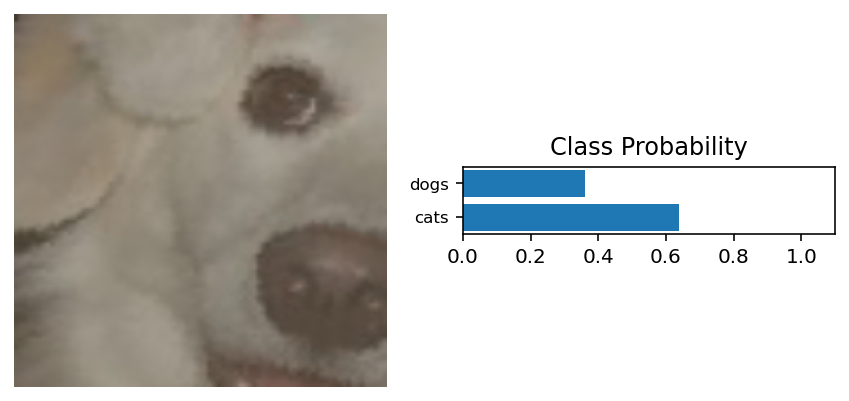

In [156]:
import numpy as np
class_list = train_data.classes

def view_classify_general(img, ps, class_list):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    imshow(img, ax=ax1, normalize=True)
    ax1.axis('off')
    ax2.barh(np.arange(len(class_list)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(class_list)))
    ax2.set_yticklabels([x for x in class_list], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

images, labels = next(iter(trainloader))
img, label = images[0], labels[0]
# Flatten images
# Forward pass, get our logits
logits = net(img.view(1, *images[0].shape))
# Calculate the loss with the logits and the labels
ps = torch.exp(logits)
    
view_classify_general(img, ps, class_list)

You should get something cute like this:

![image](imgs/cat_pred.png)


In [221]:
# exercise: try do reshape the imgs and do a CNN

new_train_transform = transforms.Compose([transforms.Resize(30),
                                        transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(28),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])



new_test_transform = transforms.Compose([transforms.Resize((28,28)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])


data_dir = "../input/cat-and-dog" # or the path where you have downloaded the dataset

new_train_data = datasets.ImageFolder(data_dir + '/training_set/training_set', transform=new_train_transform)
new_test_data = datasets.ImageFolder(data_dir + '/test_set/test_set', transform=new_test_transform)

new_trainloader = torch.utils.data.DataLoader(new_train_data, batch_size=32, shuffle=True)
new_testloader = torch.utils.data.DataLoader(new_test_data, batch_size=32, shuffle=False)

In [225]:
class Catdog(nn.Module):
    def __init__(self):
        super(Catdog, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x




catdog = Catdog()

In [226]:
epochs = 3
print_every = 40
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(catdog.parameters(), lr=0.001)

for e in range(epochs):
    running_loss = 0
    total = 0
    correct = 0
    print(f"Epoch: {e+1}/{epochs}")

    catdog.train()
    for i, (images, labels) in enumerate(iter(new_trainloader)):

        
        
        optimizer.zero_grad()
        
        output = catdog.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
        

    catdog.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(new_testloader)):
            outputs = catdog(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network: %d %%' % (
        100 * correct / total))

Epoch: 1/3
torch.Size([32, 32, 5, 5])


ValueError: Expected input batch_size (25) to match target batch_size (32).

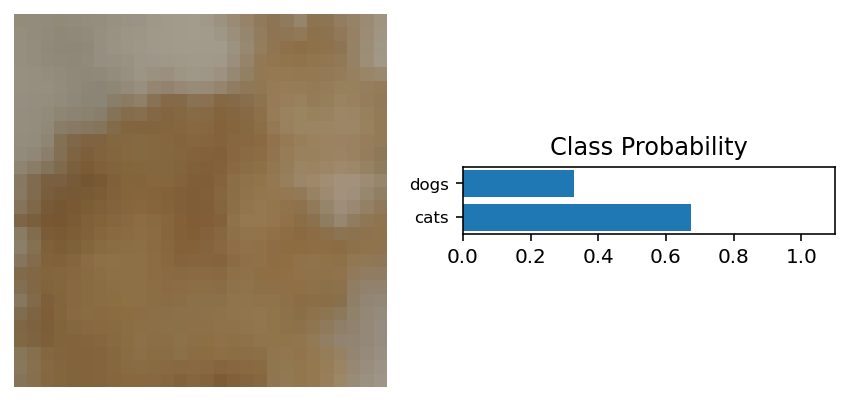

In [220]:
import numpy as np
class_list = train_data.classes

def view_classify_general(img, ps, class_list):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    imshow(img, ax=ax1, normalize=True)
    ax1.axis('off')
    ax2.barh(np.arange(len(class_list)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(class_list)))
    ax2.set_yticklabels([x for x in class_list], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

images, labels = next(iter(new_trainloader))
img, label = images[0], labels[0]
# Flatten images
# Forward pass, get our logits
# Calculate the loss with the logits and the labels
ps = torch.exp(logits)
    
view_classify_general(img, ps, class_list)